In [1]:
!pip install mpi4py

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
%%writefile spectrogram.py

import matplotlib.pyplot as plt
from mpi4py import MPI
import numpy as np

def sine_wave_packet(f=1., t=np.arange(10), t_shift=0., gain=20.):
    """
    F - frequency [Hz]
    t - time [cycles] - time range
    t_shift - time shift relating 0 (<0 - right; >0 - left) [cycles]
    gain - decay rate: less gain - higher decay
    """
    return np.sin(2 * np.pi * f * t) * np.exp(-(2 * np.pi * (t - t_shift)) ** 2 / 2 / gain ** 2)

def get_windowed(rank, n_proc, y = np.arange(10), t = np.arange(10), width = 1.):
    windowed_ys = []
    t0 = t[0]
    delta_t = t[1] - t[0]
    step = n_samples // n_proc
    for i in range(step * rank, step * (rank + 1), 1):
        pos = t0 + delta_t * i
        window_function = np.exp(-(2 * np.pi * (t - pos))**2 / 2 / (2 * np.pi * width) ** 2)
        windowed_ys.append(y * window_function)
    return windowed_ys

def get_specgram(rank, n_proc, y, t = np.arange(10), width = 1.):
    windowed = np.array(get_windowed(rank, n_proc, y, t, width))
    spect = []
    for i in range(windowed.shape[0]):
        y_window = windowed[i]
        spectrum = np.fft.fft(y_window) # get spectrum
        spect.append(abs(spectrum[0:int(spectrum.shape[0] / 2 - 1)])**2) # get one half of the spectrum
    spectrogram = np.array(spect)
    return spectrogram


t_min = -20
t_max = 20
n_samples = 2**12
t = np.linspace(t_min, t_max, n_samples)
y = sine_wave_packet(1, t) + sine_wave_packet(3, t) + sine_wave_packet(5.5, t, 10, 5)

comm = MPI.COMM_WORLD
n_proc = comm.Get_size() # processors
rank = comm.Get_rank() # current rank

if rank == 0:
    t0 = MPI.Wtime() # measure start time

spectrogram = get_specgram(rank, n_proc, y, t)
spectrogram = comm.gather(spectrogram, root=0)

if rank == 0:
    a = []
    # get all parts of spectrogram
    for i in range(n_proc):
        a.append(np.rot90(spectrogram[i]))

    # spectrogram parts concatenation
    out = np.concatenate((a), axis=1)

    # total time of calculation
    t = MPI.Wtime() - t0
    with open('./time.csv', 'a+') as f:
         f.write(f'{n_proc}, {np.round(t, 4) * 1000}\n')

    plt.figure(figsize=(16, 12))
    plt.imshow(out)
    plt.colorbar()
    plt.xticks(np.linspace(0, n_samples, 9), np.round(np.linspace(t_min, t_max, 9), 2), fontsize=16)
    plt.yticks(np.linspace(0, n_samples / 2 - 1, 11), np.round(np.linspace(6, 0, 11), 2), fontsize=16)
    plt.xlabel('t, cycles', fontsize=16)
    plt.ylabel('Frequency, arb. units', fontsize=16)
    plt.savefig(f'./spectrogram_{n_proc}_processes', dpi=200)
    plt.close()

Overwriting spectrogram.py


In [3]:
%%bash
for k in {1..10}
do
    for i in {1..8}
    do
      mpirun --oversubscribe -n $i python3 spectrogram.py   
    done
done

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import pandas as pd

In [5]:
time = pd.read_csv("./time.csv", header=None, names=["n_proc", "time"])
time.head()

,n_proc,time
0,1,767.0
1,2,427.4
2,3,342.3
3,4,292.3
4,5,289.4


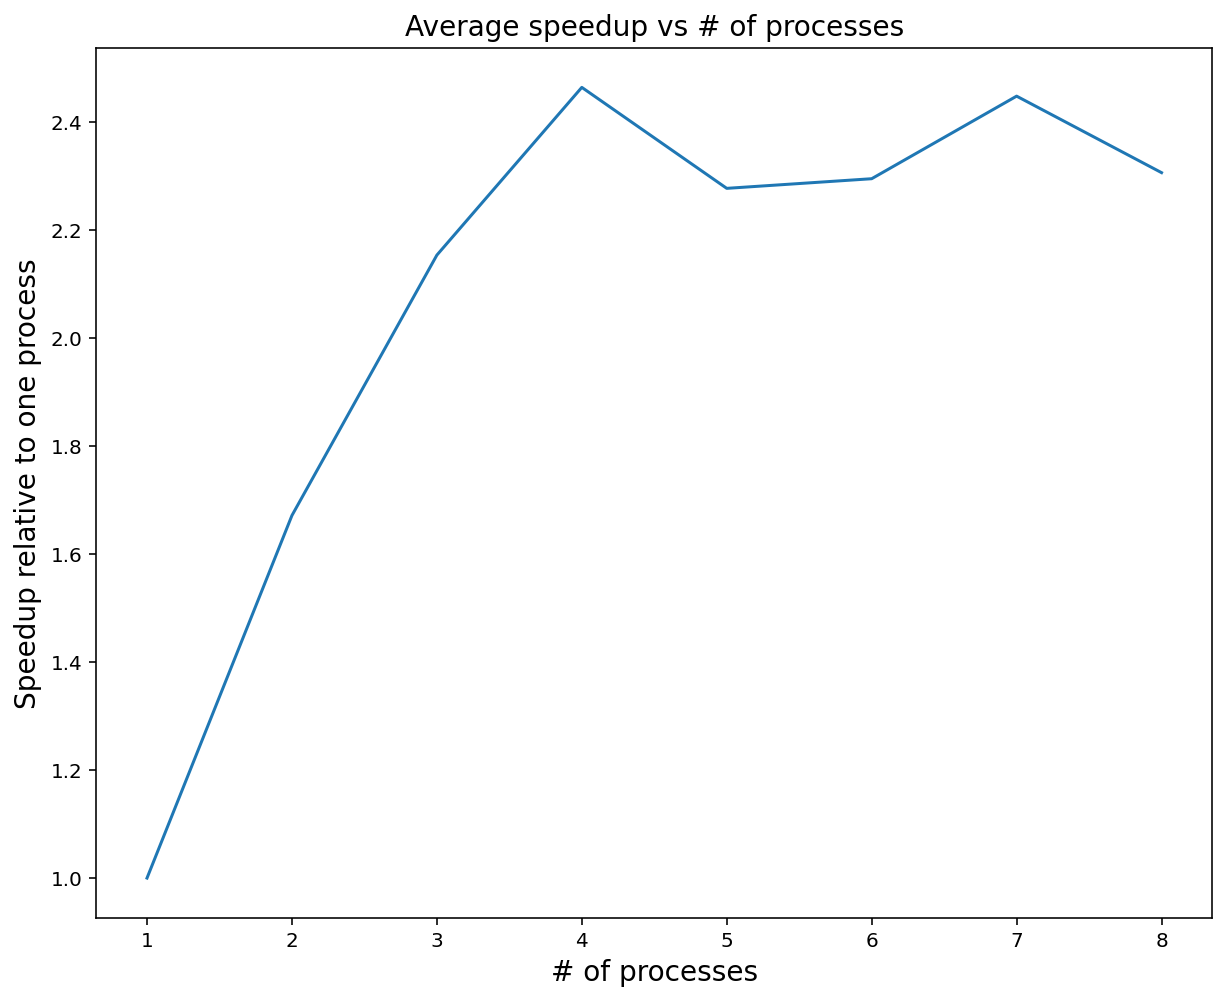

In [6]:
times = time.groupby("n_proc")['time'].mean()
plt.figure(figsize=(10,8))
plt.plot(times[1] / times)
plt.title('Average speedup vs # of processes', fontsize=14)
plt.ylabel('Speedup relative to one process', fontsize=14)
plt.xlabel('# of processes', fontsize=14)
plt.show()

On average, paralellization of our algorithm indeed provides speedup almost linear by # of processes, although, too much processess create a too big overhead and don't improve excecution time.